In [1]:
import sys
import os, sys, tarfile
import numpy as np
import matplotlib.pyplot as plt
import urllib
from PIL import Image
from keras.optimizers import RMSprop, SGD

from keras.models import load_model
import keras.backend as K
import data_preprocessing, data_generator, visual, label_parser, data_postprocessing
import pdb
import tensorflow as tf

%matplotlib inline

%load_ext autoreload
%autoreload 2
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

Using TensorFlow backend.


In [2]:
TRAIN_PATH = '../udacity_driving_datasets/'
TEST_PATH = '../udacity_driving_datasets/'

In [3]:
train_ann = label_parser.parse_annotation_json(TRAIN_PATH, 'labels_train.json')
test_ann = label_parser.parse_annotation_json(TEST_PATH, 'labels_val.json')
print("len(train_ann) = ",len(train_ann))
print("len(test_ann) = ", len(test_ann))

len(train_ann) =  16217
len(test_ann) =  833


In [4]:
size = 300
config_train = {'grid_w':9, 'grid_h':9, 'img_w' : size, 'img_h' : size, 'is_augment' : True,  'batch_size' : 32}
config_test  = {'grid_w':9, 'grid_h':9, 'img_w' : size, 'img_h' : size, 'is_augment' : False, 'batch_size' : 100}

In [5]:
trainGenerator = data_generator.BatchGenerator(train_ann, config_train)
testGenerator = data_generator.BatchGenerator(test_ann, config_test)

data will be augmented with random flip and random left-right shift on 30.0 pixels and top-bottom shift on 30.0 pixles.
iteration_num =  507
iteration_num =  9


In [6]:
import tensorflow as tf

config = tf.ConfigProto()    #to limit TensorFlow resources
config.gpu_options.allow_growth = True
tf.Session(config = config)

In [7]:
from keras.models import Model
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Reshape, Activation, BatchNormalization

GRID_W = config_train['grid_w']
GRID_H = config_train['grid_h']
input_w = config_train['img_w']
input_h = config_train['img_h']

img_input = Input(shape=(input_w, input_h, 3), name = 'image_input')

#TODO - experiment with decreasing conv filter num
x = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same')(img_input)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D()(x) 

x = Conv2D(filters = 24, kernel_size = (3, 3), padding = 'same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D()(x) 

x = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D()(x) 

x = Conv2D(filters = 48, kernel_size = (3, 3), padding = 'same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D()(x) 

x = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same')(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPooling2D()(x) 

x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(5*GRID_W*GRID_H)(x)
x = Reshape((GRID_W, GRID_H, 5))(x)

model = Model(inputs=img_input, outputs=x)

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 300, 16)      448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 300, 300, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 300, 300, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 24)      3480      
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 150, 24)      96        
__________

In [9]:
import tensorflow as tf
def YOLO_loss(y_true, y_pred):
    mask_obj = K.expand_dims(y_true[..., 0], axis=-1)
    mask_no_obj = 1 - mask_obj
    loss_obj = K.sum(K.square(y_true-y_pred)*mask_obj)                             #Loss_xywhp for object
    loss_no_obj = K.sum(K.square(y_true[...,0]-y_pred[...,0])*mask_no_obj[...,0] ) #only confidence
    N_obj = tf.reduce_sum(tf.to_float(mask_obj > 0.0))
    N_no_obj = tf.reduce_sum(tf.to_float(mask_no_obj > 0.0))
    return loss_obj / (N_obj + 1e-06) + 5 * loss_no_obj / (N_no_obj + 1e-06)       #because only 1 from 5 values (p,x,y,w,h)

from keras.utils.generic_utils import get_custom_objects
from keras.models import load_model
get_custom_objects().update({"YOLO_loss": YOLO_loss})
model = load_model("YOLO_scratch", custom_objects={ 'loss': YOLO_loss } )

In [10]:
model.compile(loss=YOLO_loss, optimizer = SGD(lr=0.001, momentum=0.9), metrics=['accuracy'])

In [12]:
x_batch, y_batch = trainGenerator.__getitem__(0)
model.evaluate(x_batch, y_batch)

32/32 [==============================] - 0s 2ms/step


[6.857012748718262, 0.16126543283462524]

In [13]:
from time import time
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
checkpoint = ModelCheckpoint("model_udacity_aug.h5", monitor='val_loss', verbose=2, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.fit_generator(generator = trainGenerator, steps_per_epoch  = len(trainGenerator), epochs = 100, validation_data = testGenerator, verbose = 1, callbacks=callbacks_list)

Epoch 1/100
506/507 [============================>.] - ETA: 0s - loss: 1.8182 - acc: 0.0703epoch is finished
epoch is finished
507/507 [==============================] - 136s 268ms/step - loss: 1.8174 - acc: 0.0703 - val_loss: 3.4400 - val_acc: 0.0677

Epoch 00001: val_loss improved from inf to 3.44003, saving model to model_udacity_aug.h5
Epoch 2/100
375/507 [=====================>........] - ETA: 32s - loss: 1.2087 - acc: 0.0631

only flip - 87s - no crash
flip + rotation - 231s - no crash
flip + width and height shift_range -  231s - no crash
flip +  shear_range zoom_range - 231s - no crash


112x112x3 (4 conv-pool) lr = 0.001 epoch - 90 sec, 10 epoch, loss - 0.3?, AP = 0.6?
224x224x3 (5 conv-pool) lr = 0.001, epoch - 120 sec, 3 epoch - loss 0.5, 10 epoch, loss - 0.26, AP = 0.66
20 epoch, loss = 0.1562, AP = 0.763

In [ ]:
model.save("YOLO_Udacity2")

In [ ]:
K.set_value(model.optimizer.lr, 0.0001)
model.fit_generator(generator = trainGenerator, steps_per_epoch  = len(trainGenerator), epochs = 100, validation_data = testGenerator, verbose = 1)

In [ ]:
model.save("YOLO_Udacity3")

loss: 0.1340 - the best

In [22]:
model.save("YOLO_Udacity")

In [15]:
x_batch, y_batch = testGenerator.__getitem__(0)
img_num = 1
y_pred = model.predict(x_batch[img_num:img_num+1])
np.set_printoptions(precision=3, suppress = True)

print(y_pred[0,:,:,0])

[[ 0.013  0.09   0.045  0.083  0.012  0.018 -0.031]
 [-0.011 -0.03  -0.087  0.033  0.025  0.063 -0.003]
 [-0.001 -0.013 -0.    -0.023 -0.01  -0.006 -0.   ]
 [ 0.967  0.049  0.069  0.397  0.264  0.135  0.479]
 [ 0.349 -0.012  0.126  0.021 -0.048 -0.064 -0.036]
 [ 0.009 -0.068 -0.068 -0.037 -0.016 -0.009 -0.061]
 [ 0.084 -0.087 -0.03   0.048  0.007 -0.007 -0.077]]


In [16]:
y_batch[img_num:img_num+1][0,:,:,0]

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [17]:
decoder = data_postprocessing.Encoder(GRID_W, GRID_H, input_w, input_h, 0.5)

In [18]:
pred_rects_encoded, scores = decoder.encode(y_pred)
GT_rects_encoded  = decoder.encode_GT(y_batch[img_num:img_num+1])

In [19]:
pred_rects_encoded[0]

array([[  4.974, 109.162,  33.931, 142.3  ]], dtype=float32)

In [20]:
GT_rects_encoded[0]

array([[  0.   , 107.52 ,  28.   , 140.373],
       [179.2  ,  91.84 , 202.533, 119.467]])

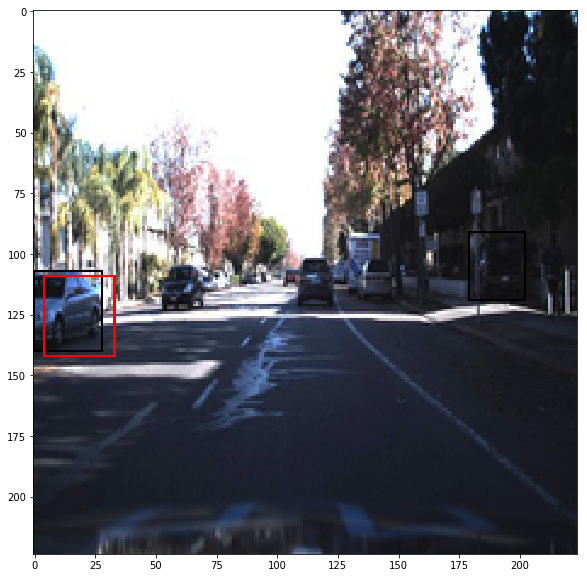

In [21]:
test_image = x_batch[img_num]*255.0

plt.rcParams['figure.figsize'] = 10, 10


plt.imshow(visual.draw_image_pred_GT(test_image, GT_rects_encoded[0], pred_rects_encoded[0]) )